# Accessing and analysing a REMO dataset

[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/remo-rcm/pyremo/blob/master/notebooks/remo-dataset.ipynb)

In this notebook we want to show some typical data analysis that might be useful to look at after or during a REMO run.

In [1]:
import pyremo as pr
#from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
#from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


We will do the processing at DKRZ where we reserve a shared node for distributed computing with dask.

In [2]:
from dask.distributed import Client, progress
client = Client()
client

<Client: 'tcp://127.0.0.1:34766' processes=6 threads=24, memory=29.30 GiB>

## Access and preparation of REMO output

For this notebook, we use 10 years of preliminary test results from a REMO run using ERA5 data as lateral boundary forcings. We will only use monthly mean data for this analysis, so let's catch that data from the filesystem:

In [8]:
import glob
pattern = '/work/ch0636/g300046/remo_results_056000/*/e056000m*.nc'
filenames = glob.glob(pattern)
filenames.sort()
filenames[:5]

['/work/ch0636/g300046/remo_results_056000/1979/e056000m197901.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197902.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197903.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197904.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197905.nc']

We will define a slightly different function for opening the monthly dataset that is based on some [xarray discussions on github](https://github.com/pydata/xarray/issues/1385#issuecomment-561920115).

In [9]:
def open_mfdataset(files, use_cftime=True, parallel=True, data_vars='minimal', chunks={'time':1}, 
                   coords='minimal', compat='override', drop=None, **kwargs):
    """optimized function for opening large cf datasets.

    based on https://github.com/pydata/xarray/issues/1385#issuecomment-561920115
    
    """
    def drop_all_coords(ds):
        #ds = ds.drop(drop)
        return ds.reset_coords(drop=True)
    ds = xr.open_mfdataset(files, parallel=parallel, decode_times=False, combine='by_coords', 
                       preprocess=drop_all_coords, decode_cf=False, chunks=chunks,
                      data_vars=data_vars, coords='minimal', compat='override', **kwargs)
    return xr.decode_cf(ds, use_cftime=use_cftime)



In [10]:
%time ds = open_mfdataset(filenames, parallel=True, chunks='auto')

CPU times: user 8.9 s, sys: 1.86 s, total: 10.8 s
Wall time: 42.5 s


We now have our 10 years of monthly REMO output in one dataset. Please remember, that [xarray uses dask under the hood](http://xarray.pydata.org/en/stable/user-guide/dask.html) (if you have installed it!) which means that we can easily work and analyze large datasets that would normally not fit into our memory (or because we simply don't want all data loaded and slow us down).

For historical reason, the current REMO version sets the day of the month to 0 for monthly means. This is not compatible, e.g., with standard datetime formats. We provided a function to correct the time axis here.

In [6]:
from datetime import datetime as dt

time = list(ds.time.astype(str).values)
ds['time'] = [dt.strptime(t[0:6] , '%Y%m') for t in time]

Now, we have a reasonable time axis in the dataset that makes analysis much easier:

In [7]:
ds.time[:5]

<xarray.DataArray 'time' (time: 5)>
array(['1979-01-01T00:00:00.000000000', '1979-02-01T00:00:00.000000000',
       '1979-03-01T00:00:00.000000000', '1979-04-01T00:00:00.000000000',
       '1979-05-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 1979-05-01

Now, let's have a look at the dataset:

In [8]:
ds

<xarray.Dataset>
Dimensions:                     (height10m: 1, height2m: 1, lev_4: 1, lev_5: 1, meansea: 1, nhyi: 28, nhym: 27, rlat: 433, rlon: 433, snlevs: 3, time: 132)
Coordinates:
  * rlon                        (rlon) float64 -28.93 -28.82 ... 18.49 18.6
  * rlat                        (rlat) float64 -23.93 -23.82 ... 23.49 23.6
  * meansea                     (meansea) float64 0.0
  * height10m                   (height10m) float64 10.0
  * height2m                    (height2m) float64 2.0
  * lev_4                       (lev_4) float64 1.0
  * lev_5                       (lev_5) float64 27.0
  * snlevs                      (snlevs) float64 1.0 2.0 3.0
    lon                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
    lat                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
  * time                        (time) datetime64[ns] 1979-01-01 ... 1989-12-01
Dimensions without coordinates: nhyi, nhym
Data variables: (12/129)
    hyai                        (nhyi) float64 dask.array<chunksize=(28,), meta=np.ndarray>
    hybi                        (nhyi) float64 dask.array<chunksize=(28,), meta=np.ndarray>
    hyam                        (nhym) float64 dask.array<chunksize=(27,), meta=np.ndarray>
    hybm                        (nhym) float64 dask.array<chunksize=(27,), meta=np.ndarray>
    rotated_latitude_longitude  |S1 ...
    QDB                         (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    ...                          ...
    ALSOFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    USTRFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    VSTRFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    EVAPFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    TMCHFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    SNMLRHO                     (time, snlevs, rlat, rlon) float32 dask.array<chunksize=(1, 3, 433, 433), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.9.6 (http://mpimet...
    Conventions:          CF-1.6
    history:              Mon Mar 08 09:08:20 2021: cdo -t remo -f nc copy a0...
    source:               REMO
    institution:          Max-Planck-Institute for Meteorology
    CDO:                  Climate Data Operators version 1.9.6 (http://mpimet...
    forcing_file_format:  NetCDF
    remo_version:         2.0.0
    system:               Linux eddy3 2.6.32-754.33.1.el6.x86_64 #1 SMP Mon A...

You can see that we got 129 data variables and a lot of coordinates. We will focus on some common variables for analysis. However, first, let's look at the size of the dataset.

In [9]:
ds.nbytes / 1.e9 # in GB

12.476276945

Not too bad, 12 GB would fit into the memory, e.g. at DKRZ, but probably would be too large for a laptop. It's good that we load that dataset lazily and will only load data if we need it.

It's also handy to grep the pole information about the grid mapping from the dataset for plotting:

In [10]:
pole = ( ds.rotated_latitude_longitude.grid_north_pole_longitude,  ds.rotated_latitude_longitude.grid_north_pole_latitude)
pole

(-162.0, 39.25)

## Spin up

It's always useful to look at the soil temperatures. During the run, the soil has to get into an equilibrium with the atmospheric temperature to *forget* the initial conditions.

In [11]:
#def vars_by_units(ds, units):
#    temps = [var for var in ds if ds[var].attrs.get('units', None) == units]
#    dim=xr.DataArray(data=temps, dims='var', name='var')
#    return xr.concat([ds[var]-273.5 for var in temps], dim=dim)

Let's look at the following variables:

In [12]:
temp_vars = ['TS', 'TSL', 'TEMP2', 'TSN', 'TD3', 'TD4', 'TD5']

We will extract those variables from the big dataset and stuff them into a coordinate so that we can easily plot them.

In [13]:
dim = xr.DataArray(data=temp_vars, dims='var', name='var')
temps = xr.concat([ds[var] - 273.5 for var in temp_vars], dim=dim)
temps.name = 'temperatures'
temps

<xarray.DataArray 'temperatures' (var: 7, time: 132, rlat: 433, rlon: 433, height2m: 1)>
dask.array<concatenate, shape=(7, 132, 433, 433, 1), dtype=float32, chunksize=(1, 1, 433, 433, 1), chunktype=numpy.ndarray>
Coordinates:
  * height2m  (height2m) float64 2.0
  * rlon      (rlon) float64 -28.93 -28.82 -28.71 -28.6 ... 18.37 18.49 18.6
  * rlat      (rlat) float64 -23.93 -23.82 -23.71 -23.6 ... 23.37 23.49 23.6
    lon       (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
    lat       (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
  * time      (time) datetime64[ns] 1979-01-01 1979-02-01 ... 1989-12-01
  * var       (var) <U5 'TS' 'TSL' 'TEMP2' 'TSN' 'TD3' 'TD4' 'TD5'

Great, now lets' compute the spatial means (or field mean) for the 10 years...

In [14]:
weight = np.cos(np.deg2rad(ds.rlat))
temps_mean = temps.weighted(weight).mean(dim=('rlat', 'rlon'))
temps_mean

<xarray.DataArray 'temperatures' (var: 7, time: 132, height2m: 1)>
dask.array<truediv, shape=(7, 132, 1), dtype=float64, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * height2m  (height2m) float64 2.0
  * time      (time) datetime64[ns] 1979-01-01 1979-02-01 ... 1989-12-01
  * var       (var) <U5 'TS' 'TSL' 'TEMP2' 'TSN' 'TD3' 'TD4' 'TD5'

You can see that the data is still nicely chunked. We have not triggered any computation yet because we didn't actually look at the data yet. But now, we want to plot the data. To show the computation here, we will explicitly trigger it! Usually, you could just go on with plotting and the computation is done automatically.

In [15]:
from dask.distributed import progress
%time temps_mean_ = temps_mean.persist()  # start computation
%time progress(temps_mean_)

CPU times: user 1.27 s, sys: 20 ms, total: 1.29 s
Wall time: 1.3 s
CPU times: user 5 ms, sys: 0 ns, total: 5 ms
Wall time: 5.08 ms


VBox()

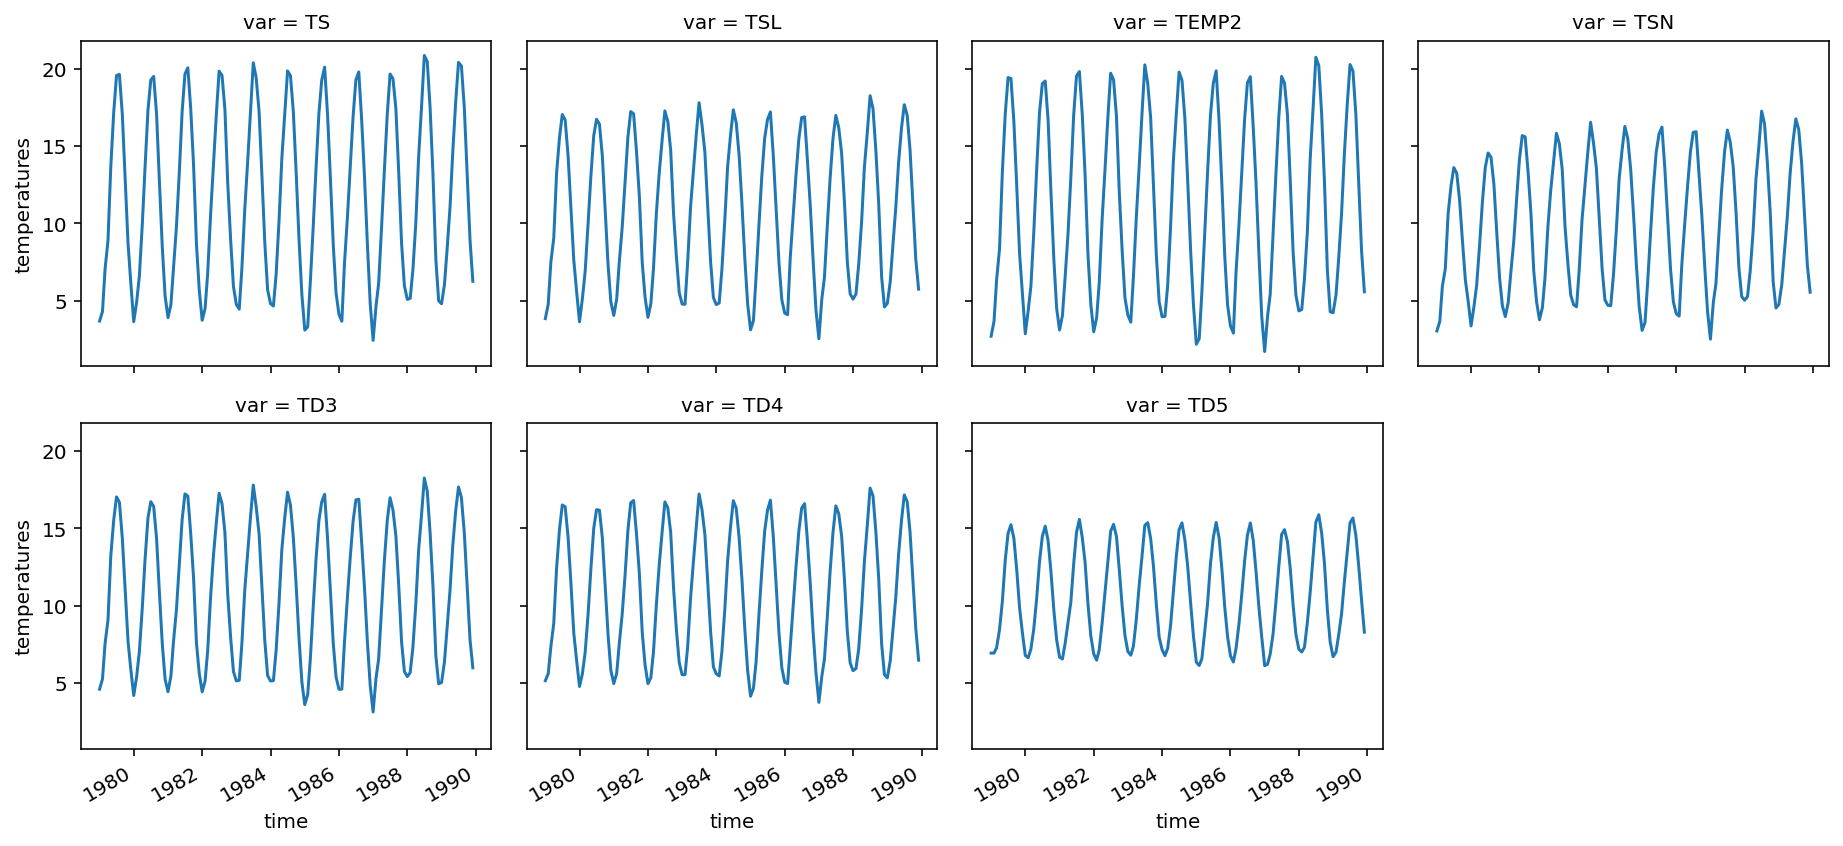

In [16]:
temps_mean_.plot(col='var', col_wrap=4)

We can see that the soil temperatures seem to be fine and in equilibrium with the atmosphere!

## Seasonal means

First, let's define a function to conveniently plot all four seasons.

In [17]:
def plot_seasons(da, pole, vmin=None, vmax=None, cmap='coolwarm'):
    """plot seasonal means"""
    from matplotlib import pyplot as plt
    import cartopy.crs as ccrs
    transform = ccrs.RotatedPole(pole[0], pole[1])
    projection = transform
    #plt.subplots_adjust(hspace=1.5, wspace=1.0)
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(
        ncols=2, nrows=2, subplot_kw={'projection': projection}, 
        figsize=(18,14))
    
    axes = (ax1, ax2, ax3, ax4)
    for ax in axes:
        #ax.set_axis_off()
        #ax.set_extent([da.rlon.min(), da.rlon.max(), da.rlat.min(), da.rlat.max()], crs=transform)
        ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
                      xlocs=range(-180,180,10), ylocs=range(-90,90,10))
        ax.coastlines(resolution='110m', color='black', linewidth=1)
    for season, ax in zip(da.season, axes):
        im = da.sel(season=season).plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, 
                                        transform=transform, add_colorbar=False)
    cbar = fig.colorbar(im, ax=axes)
    return plt

Now, we compute seasonal means with a simple groupy approach.

In [18]:
temp2_seasmean = ds.TEMP2.groupby('time.season').mean(dim='time')
%time temp2_seasmean_ = temp2_seasmean.persist()  # start computation
%time progress(temp2_seasmean_)

CPU times: user 50 ms, sys: 0 ns, total: 50 ms
Wall time: 50.3 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.24 ms


VBox()

We can have a look using our nice plotting function.

<module 'matplotlib.pyplot' from '/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/matplotlib/pyplot.py'>

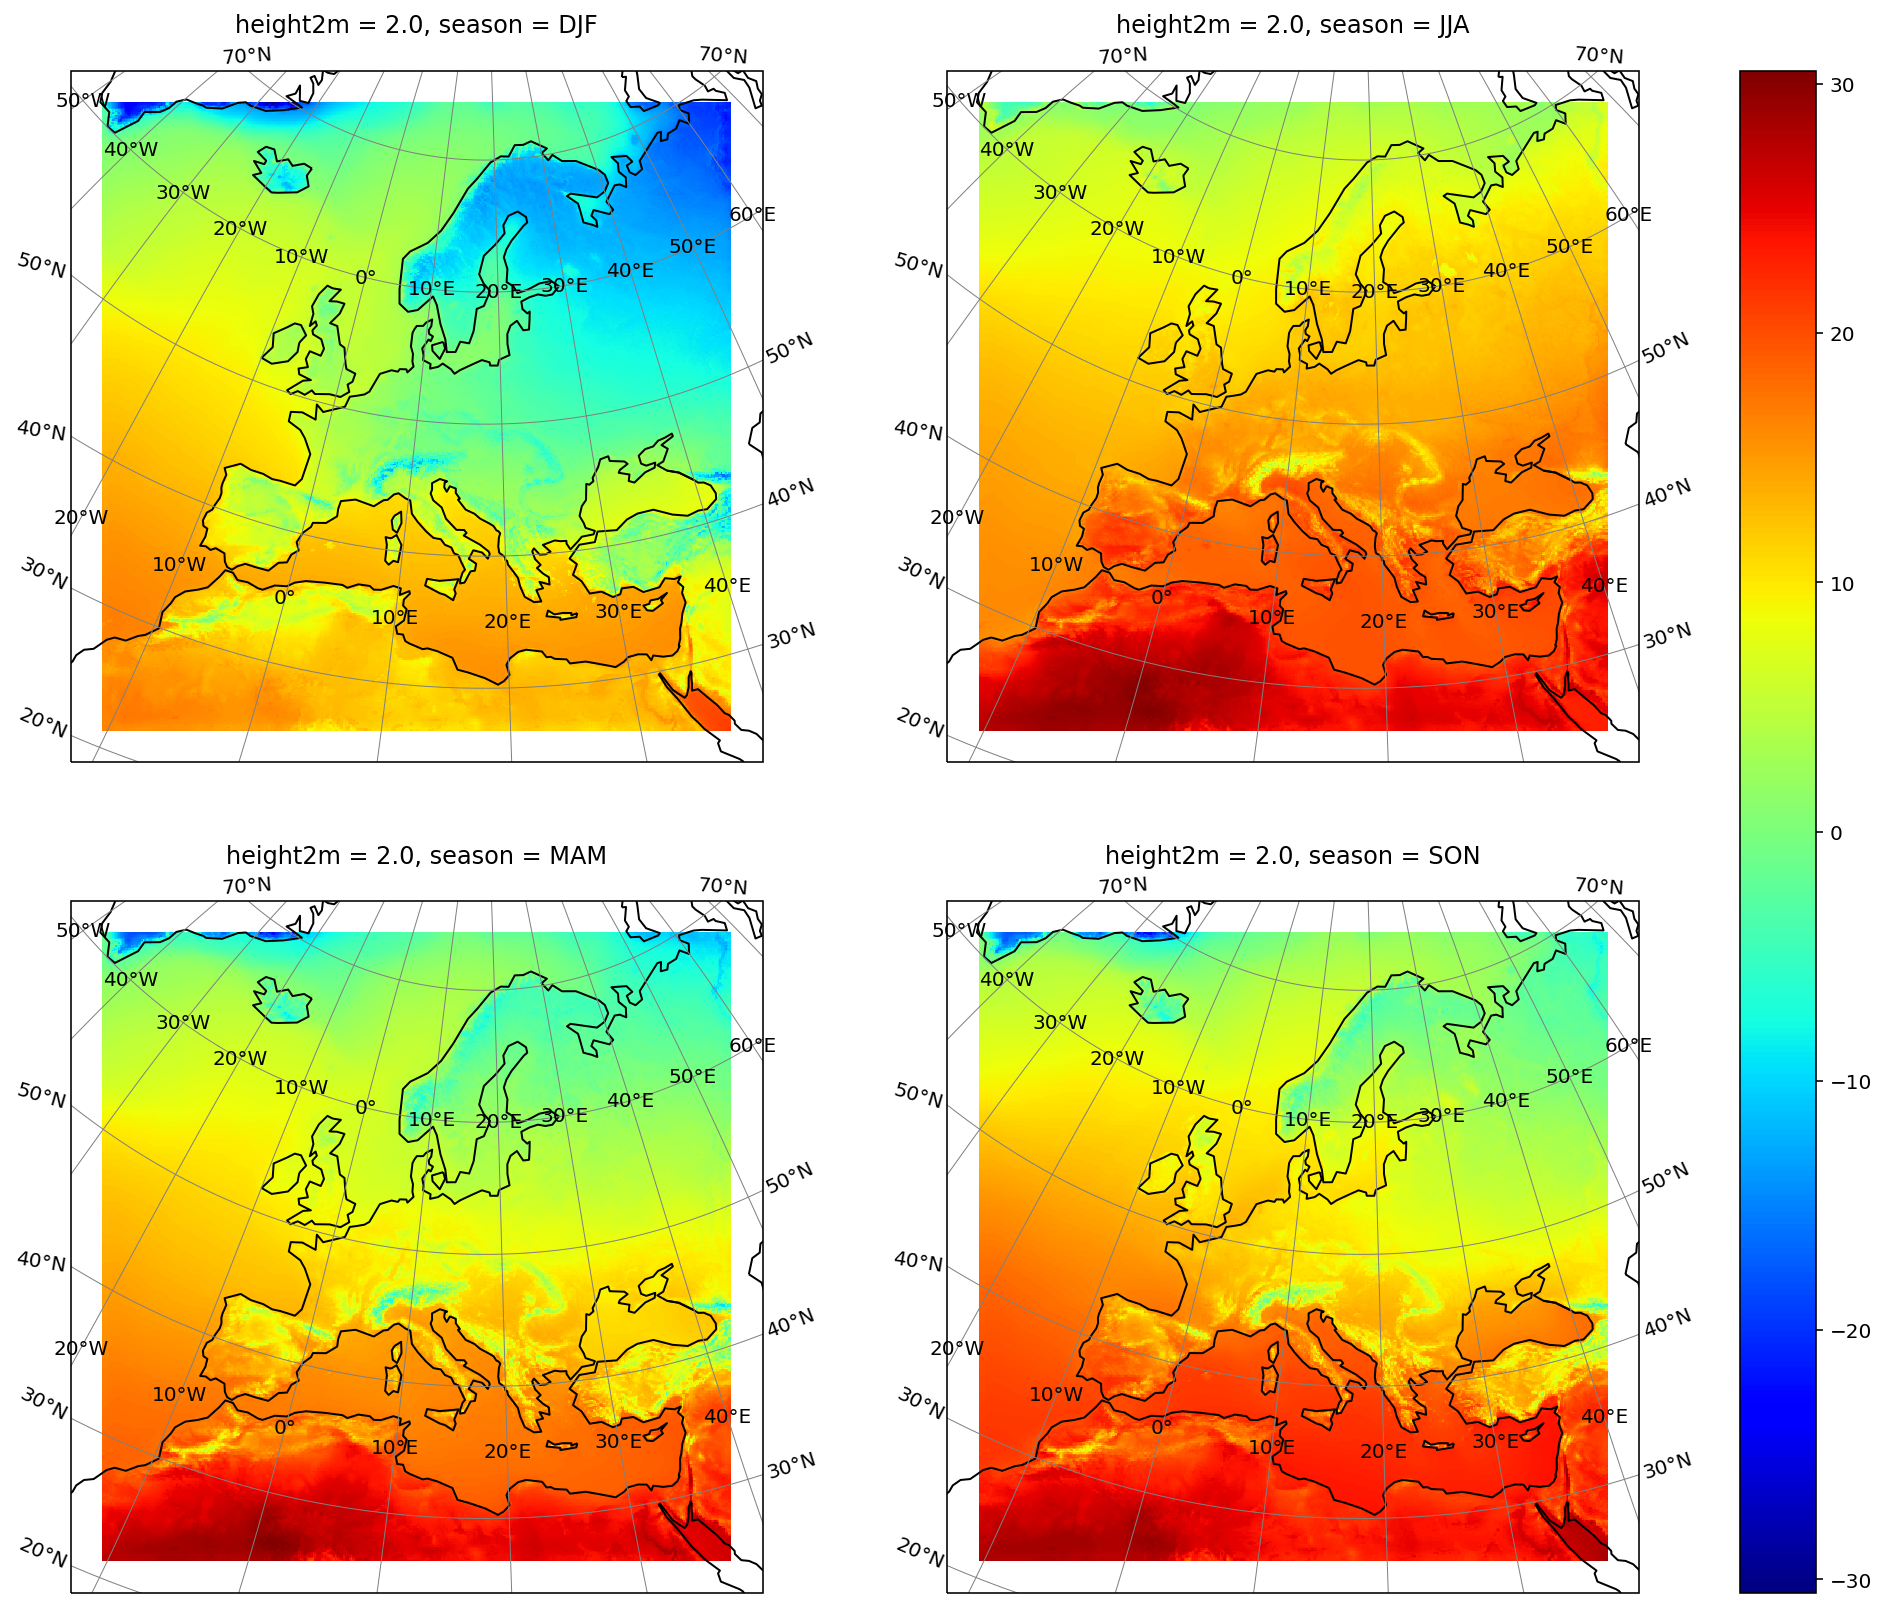

In [19]:
plot_seasons(temp2_seasmean_-273.5, pole, cmap='jet')

## Comparison with observations

This is the exciting part. Let's compare our model results with gridded observational data! We will start with [CRU TS4](https://catalogue.ceda.ac.uk/uuid/89e1e34ec3554dc98594a5732622bce9).

### CRU TS4

In [20]:
cru_base = "/mnt/lustre02/work/ch0636/eddy/pool/obs/cru/CRU/TS4.04/original/cru_ts4.04.1901.2019.{var}.dat.nc"
cru_tmp = xr.open_dataset(cru_base.format(var='tmp'), chunks='auto', use_cftime=True)

In [21]:
cru_tmp

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1428)
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) object 1901-01-16 00:00:00 ... 2019-12-16 00:00:00
Data variables:
    tmp      (time, lat, lon) float32 dask.array<chunksize=(238, 180, 240), meta=np.ndarray>
    stn      (time, lat, lon) float64 dask.array<chunksize=(238, 180, 240), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.04 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2004151855. Data generated from:tmp.2004011744.dtb
    history:      Wed 15 Apr 2020 19:58:33 BST : User ianharris : Program mak...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

The CRU data has a resolutio of roughly 50 km. To compare out REMO output with the CRU data, we will regrid the model data to the coarser CRU grid to avoid creating *artificial* observations.

In [6]:
import xesmf as xe

In [23]:
%time regridder = xe.Regridder(ds, cru_tmp, "bilinear")
regridder

CPU times: user 3.06 s, sys: 179 ms, total: 3.24 s
Wall time: 3.05 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_433x433_360x720.nc 
Reuse pre-computed weights? False 
Input grid shape:           (433, 433) 
Output grid shape:          (360, 720) 
Periodic in longitude?      False

In [24]:
remo_ts_regrid = regridder(ds.TEMP2)
remo_ts_regrid = remo_ts_regrid.where(remo_ts_regrid!=0.0)

/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


We want a mask that only shows our EUR-11 region on the CRU grid.

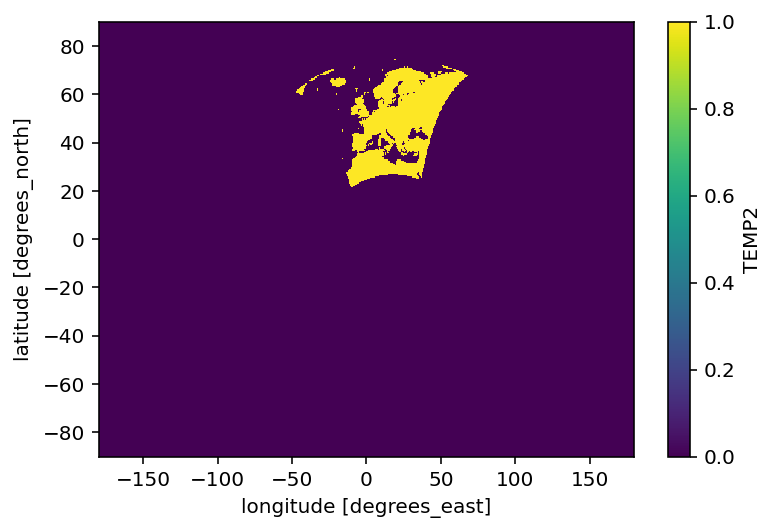

In [25]:
mask = xr.where(cru_tmp.tmp[0].isnull(), False, True)
mask = xr.where(remo_ts_regrid[0].where(mask) > 0, True, False).squeeze(drop=True) # remove height2m
mask.plot()

Compute seasonal means and difference between REMO and CRU.

In [26]:
cru_seasmean = cru_tmp.tmp.sel(time=slice("1979", "1980")).groupby('time.season').mean('time')
remo_seasmean = remo_ts_regrid.groupby('time.season').mean('time') - 273.5
diff1 = cru_seasmean - remo_seasmean

We need to define a new plotting function because we now plot on the CRU grid.

In [27]:
def plot_seasons(da, pole, vmin=None, vmax=None, cmap='bwr'):
    """plot seasonal means"""
    from matplotlib import pyplot as plt
    import cartopy.crs as ccrs
    transform = ccrs.RotatedPole(pole[0], pole[1])
    projection = transform
    #plt.subplots_adjust(hspace=1.5, wspace=1.0)
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(
        ncols=2, nrows=2, subplot_kw={'projection': projection}, 
        figsize=(18,14))
    
    axes = (ax1, ax2, ax3, ax4)
    for ax in axes:
        #ax.set_axis_off()
        ax.set_extent([ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()], crs=transform)
        ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
                      xlocs=range(-180,180,10), ylocs=range(-90,90,10))
        ax.coastlines(resolution='50m', color='black', linewidth=1)
    for season, ax in zip(da.season, axes):
        im = da.sel(season=season).plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, 
                                        transform=ccrs.PlateCarree(), add_colorbar=False)
    cbar = fig.colorbar(im, ax=axes)
    return plt

<module 'matplotlib.pyplot' from '/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/matplotlib/pyplot.py'>

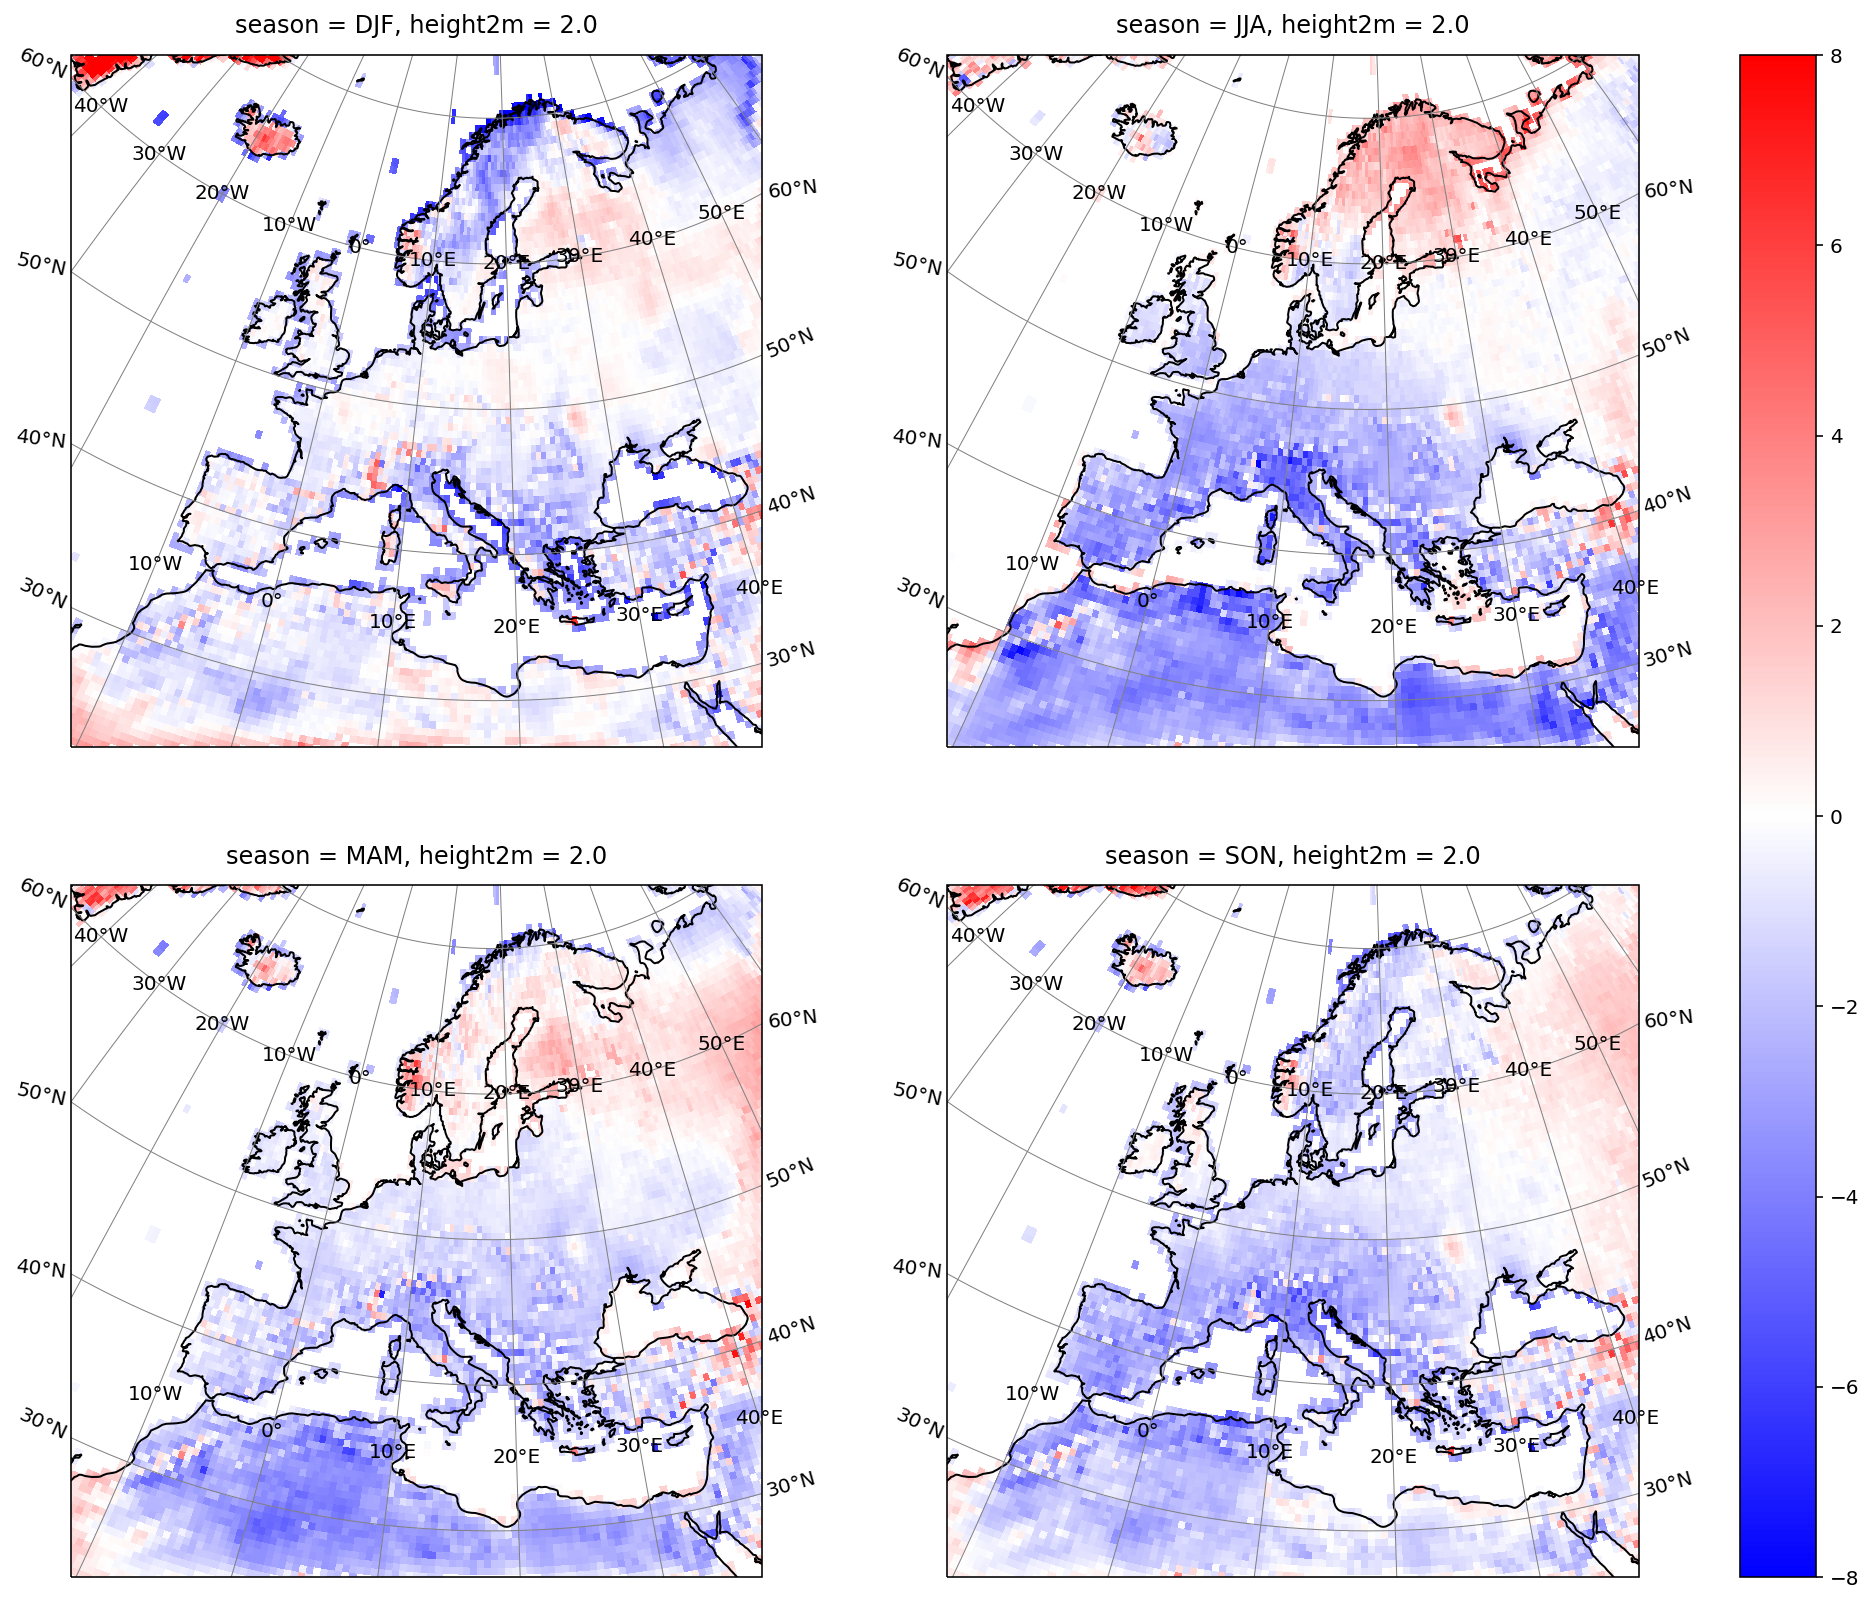

In [28]:
plot_seasons(diff1.where(mask > 0, drop=True), pole, vmin=-8, vmax=8)

This seems to be ok. The question is to get rid of the remapping artifcats? For example, do you use the REMO land sea mask before regridding?

#### Height correction

We will add a height correction based on the different topographies. Let's define a function for this:

In [29]:
def height_correction(height1, height2):
    """returns height correction in m"""
    return (height1 - height2) * 0.0065

I found this topography file for CRU:

In [30]:
cru_topo = xr.open_dataset("/mnt/lustre02/work/ch0636/eddy/pool/obs/cru/CRU/TS4.04/original/cru404_c129.nc").topo
cru_topo

<xarray.DataArray 'topo' (lat: 360, lon: 720)>
[259200 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Attributes:
    units:    m

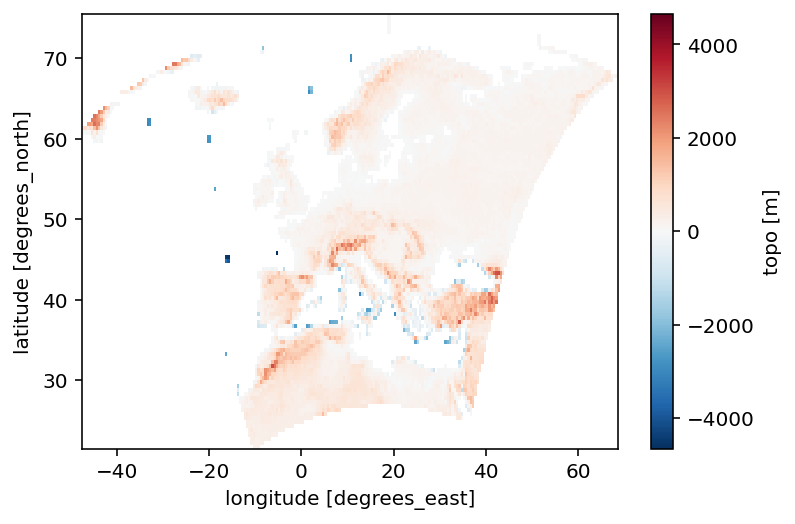

In [31]:
cru_topo.where(mask > 0, drop=True).plot()

We grab the REMO topography from a t-file

In [32]:
import tarfile
import os
tar = tarfile.open('/work/ch0636/g300046/remo_results_056000/1979/e056000t197901.tar')
scratch = os.environ.get('SCRATCH')
path = os.path.join(scratch,'remo-tmp')
remo_topo = xr.open_dataset(tar.extractfile('e056000t1979010106.nc')).FIB.isel(time=0, drop=True)

In [33]:
remo_topo

<xarray.DataArray 'FIB' (rlat: 433, rlon: 433)>
[187489 values with dtype=float32]
Coordinates:
  * rlon     (rlon) float64 -28.93 -28.82 -28.71 -28.6 ... 18.37 18.49 18.6
  * rlat     (rlat) float64 -23.93 -23.82 -23.71 -23.6 ... 23.37 23.49 23.6
    lon      (rlat, rlon) float64 ...
    lat      (rlat, rlon) float64 ...
Attributes:
    long_name:     surface geopotential (orography)
    units:         m
    code:          129
    leveltype:     1
    grid_mapping:  rotated_latitude_longitude

In [34]:
remo_topo_regrid = regridder(remo_topo)

/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


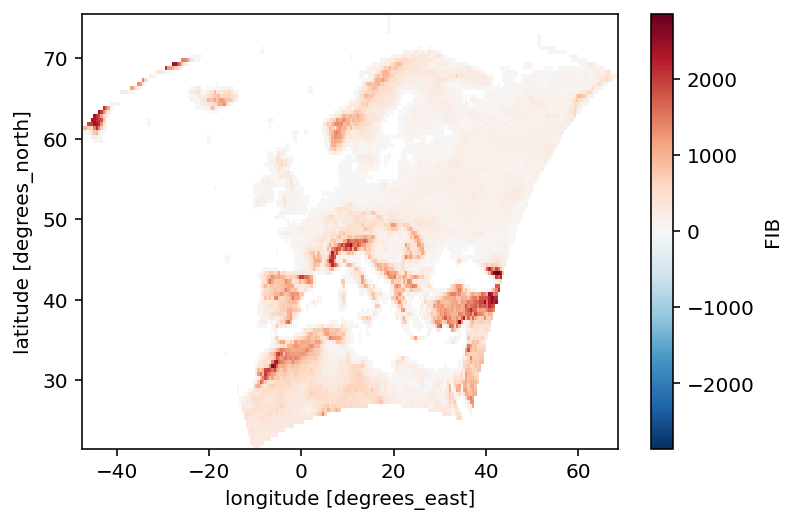

In [35]:
remo_topo_regrid.where(mask > 0, drop=True).plot()

In [36]:
correction = height_correction(cru_topo, remo_topo_regrid)

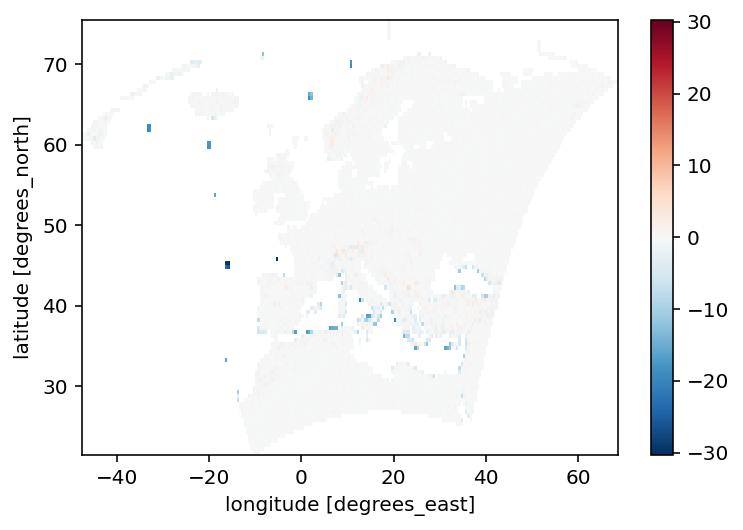

In [37]:
correction.where(mask > 0, drop=True).plot()

<module 'matplotlib.pyplot' from '/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/matplotlib/pyplot.py'>

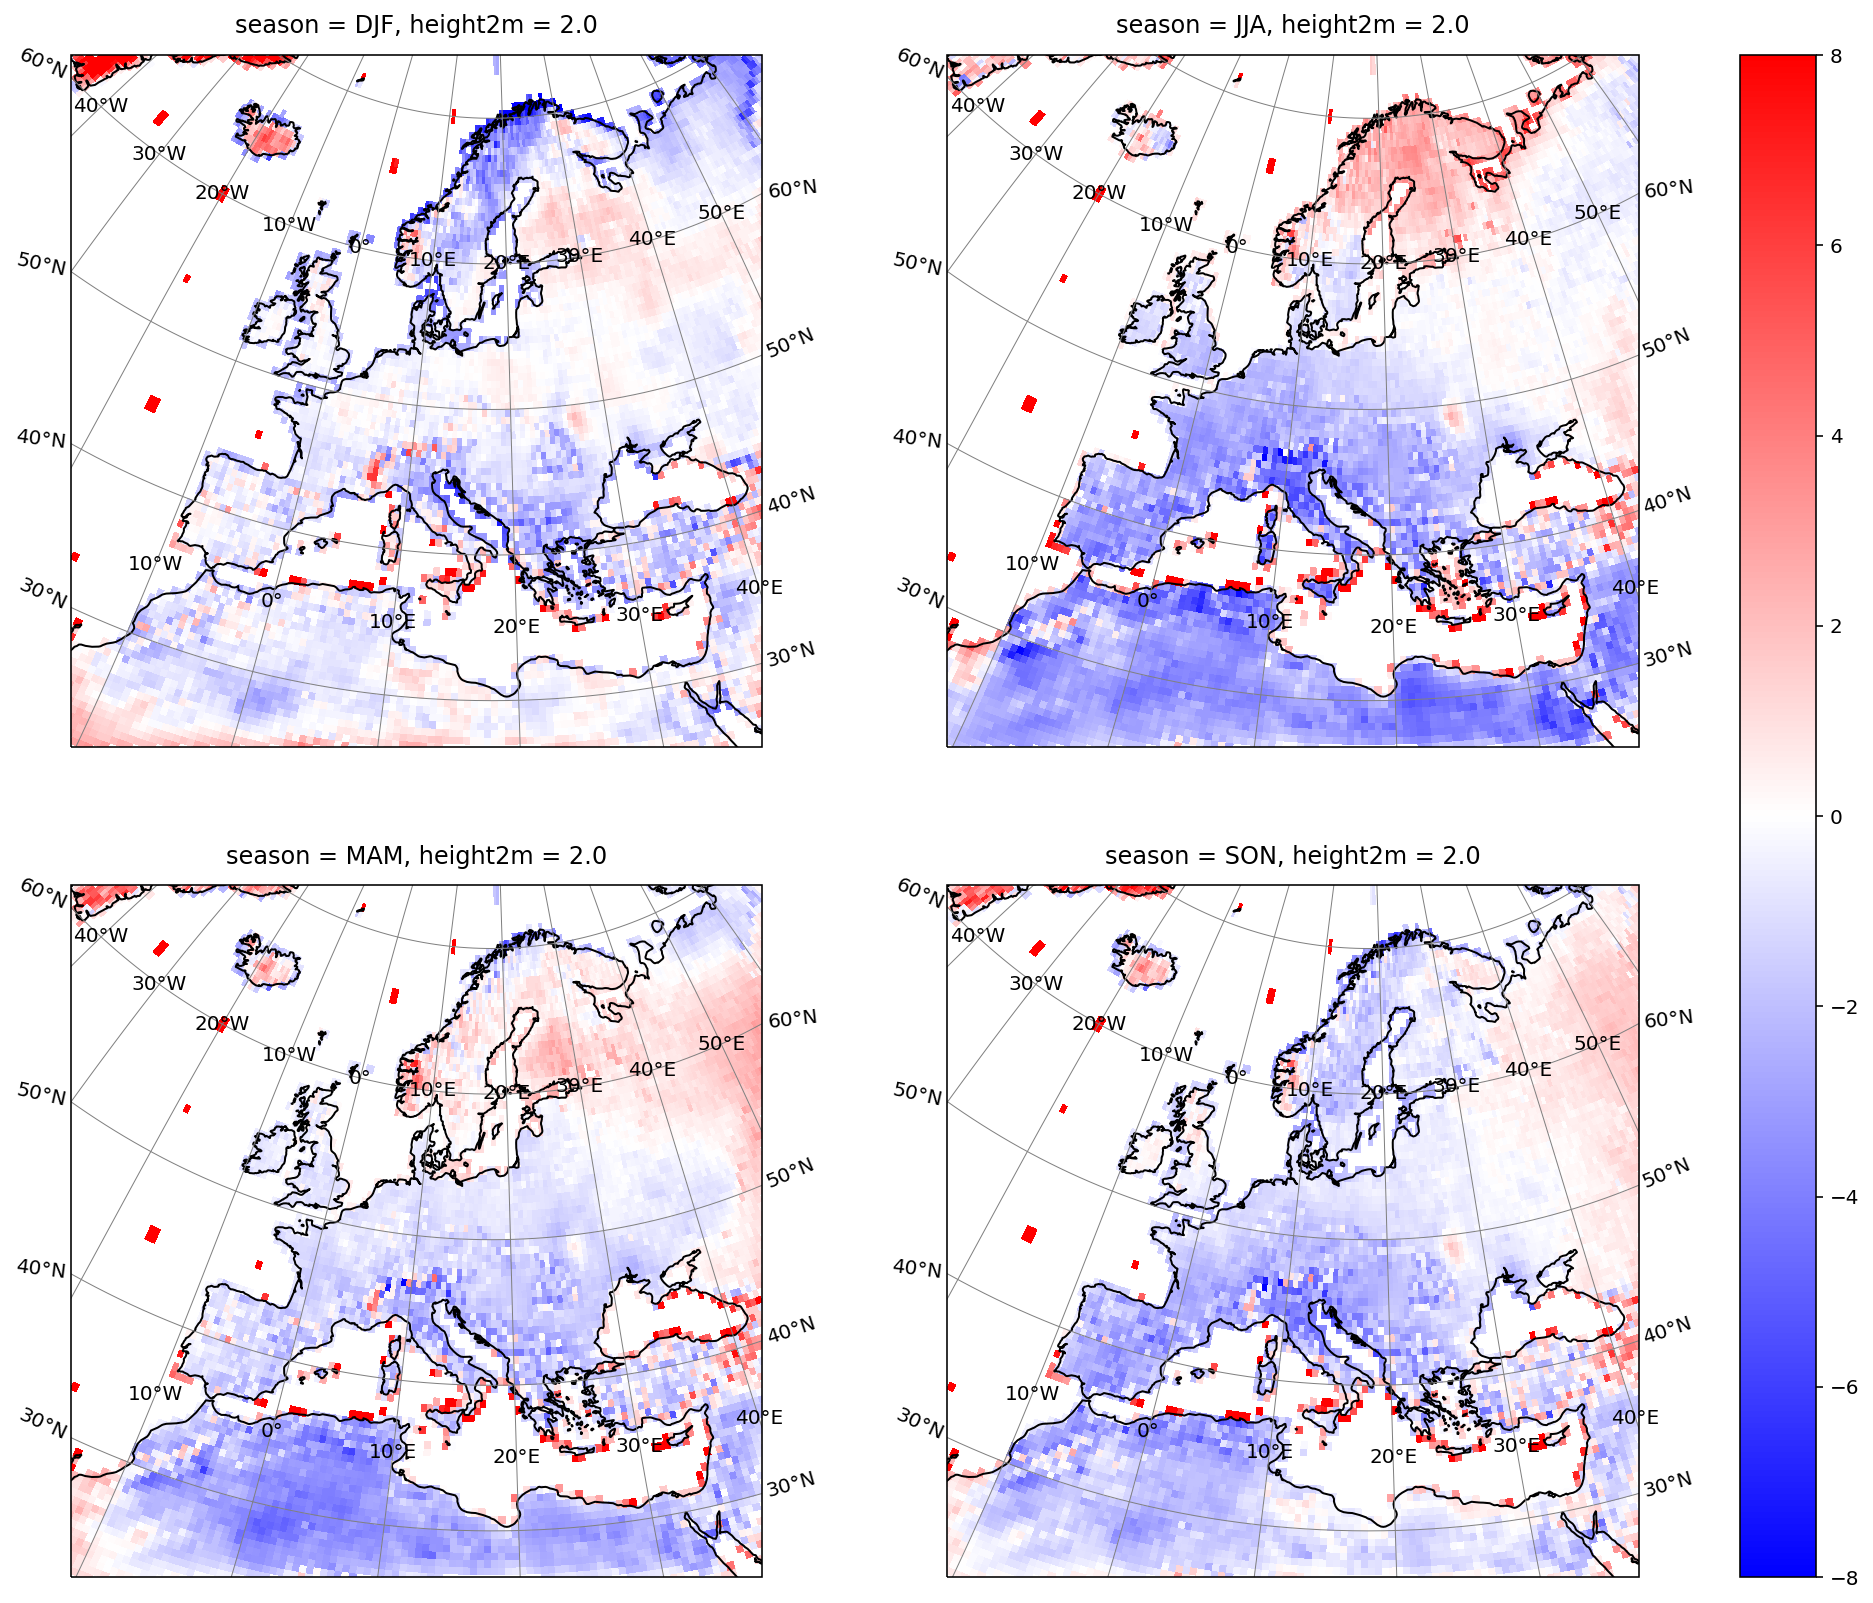

In [38]:
cru_seasmean = cru_tmp.tmp.sel(time=slice("1979", "1980")).groupby('time.season').mean('time')
remo_seasmean = (remo_ts_regrid+correction).groupby('time.season').mean('time') - 273.5
diff2 = cru_seasmean - remo_seasmean
plot_seasons(diff2.where(mask > 0, drop=True), pole, vmin=-8, vmax=8)

Now, let's look at the bias difference that we get from the height correction

<module 'matplotlib.pyplot' from '/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/matplotlib/pyplot.py'>

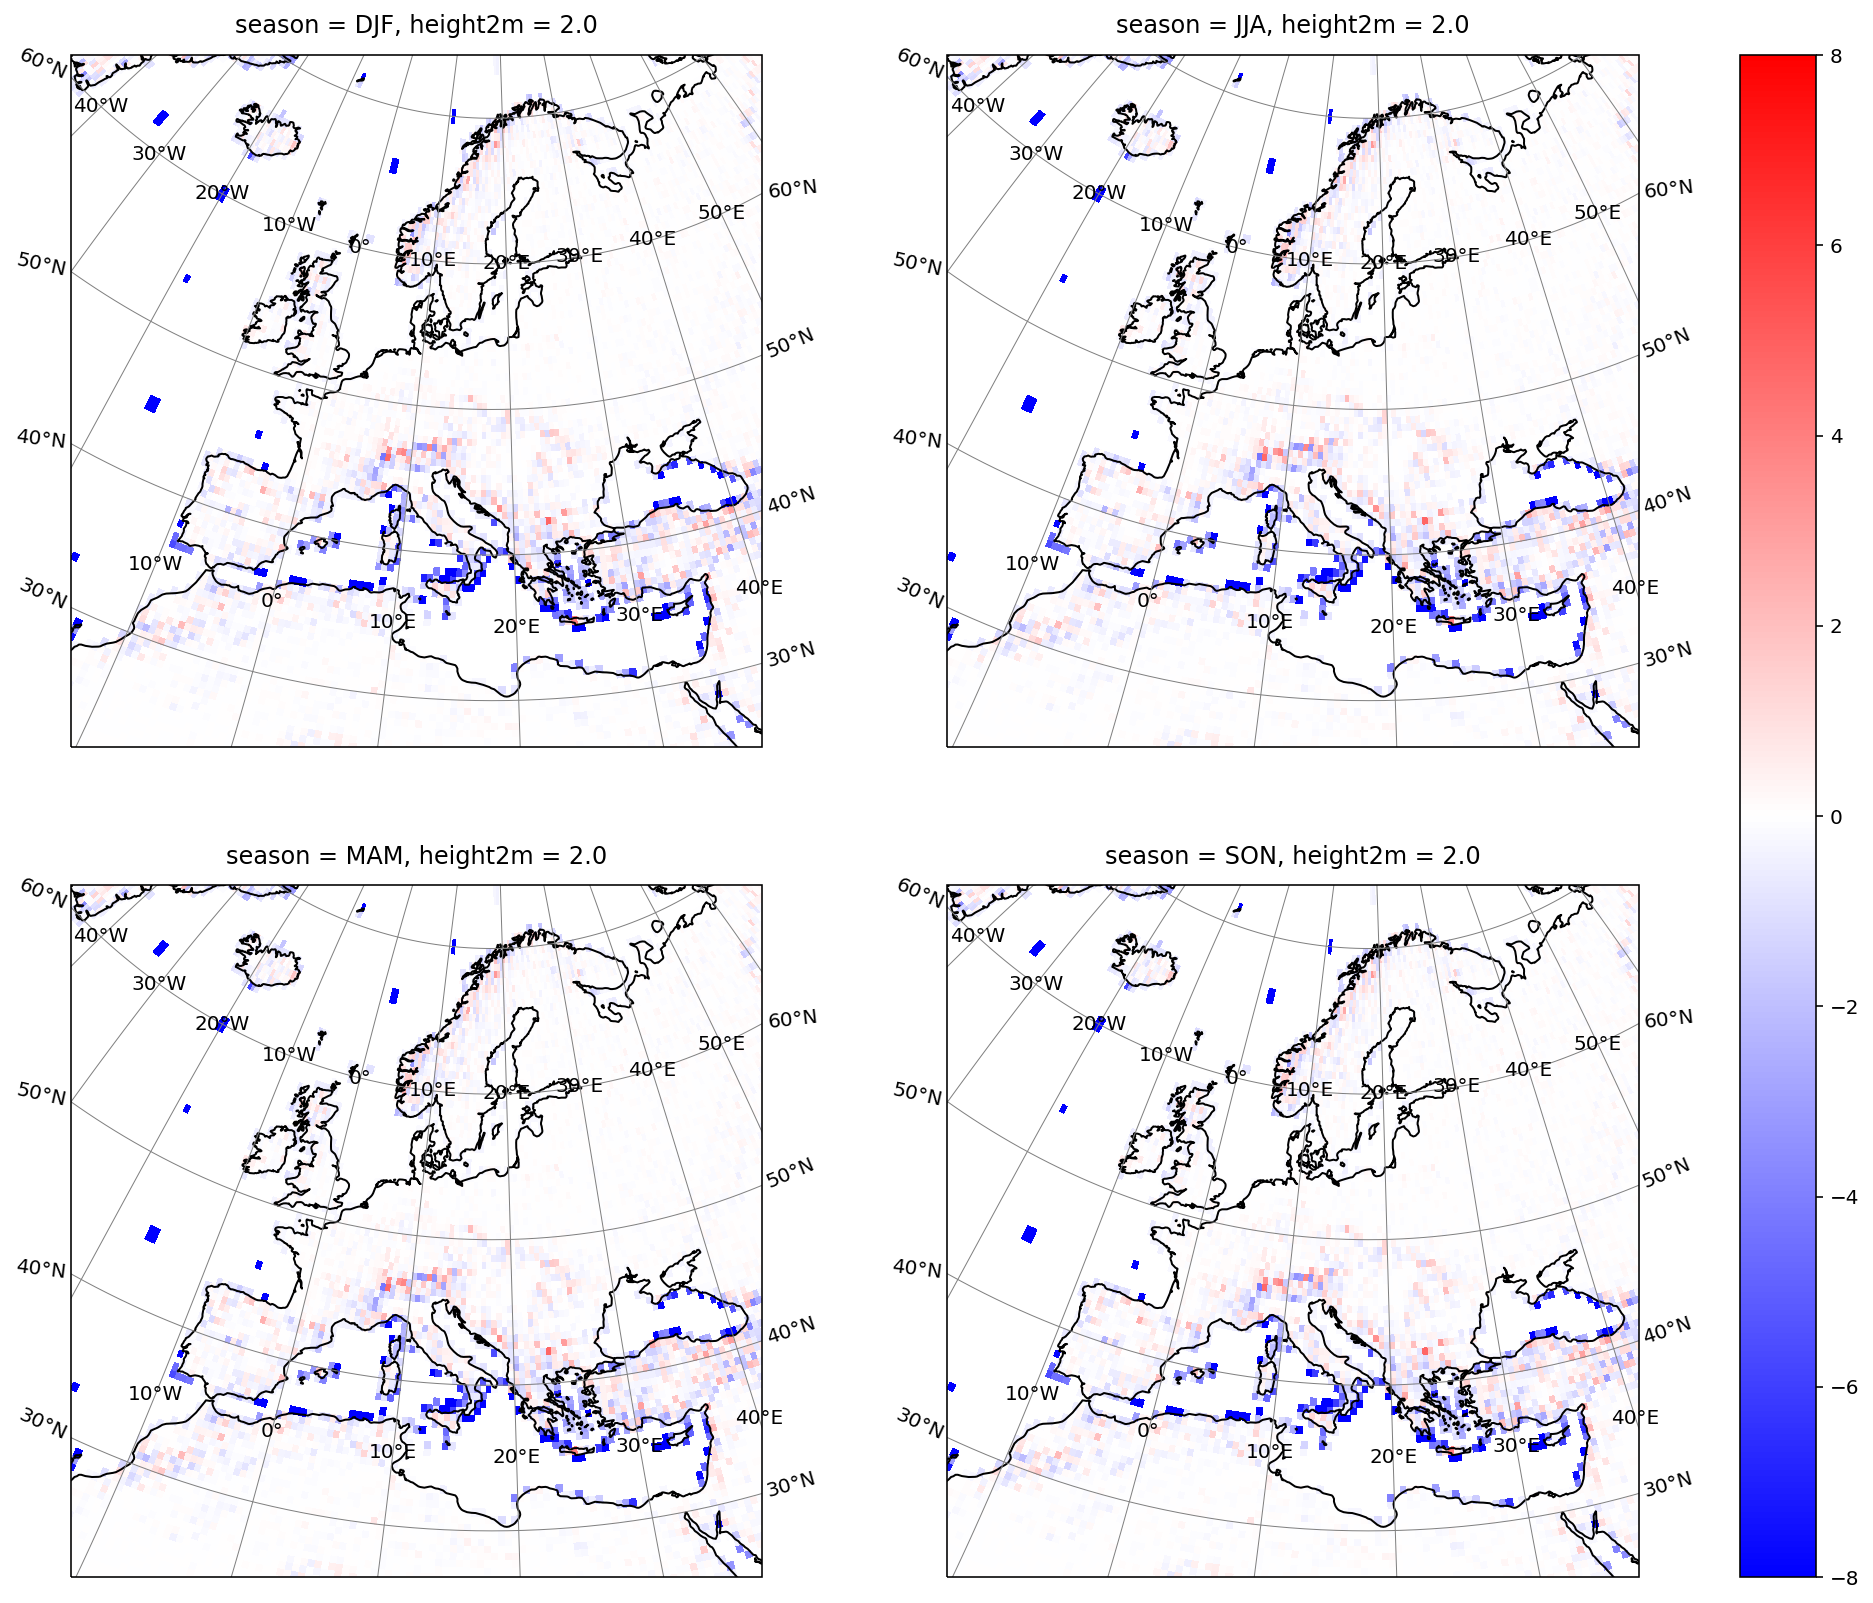

In [40]:
plot_seasons((diff1-diff2).where(mask > 0, drop=True), pole, vmin=-8, vmax=8)

How can we get rid of those coastline artifacts? Should we mask REMO data by its own land sea mask before regridding? REMO topography has no sea topography but CRU has. That's why we get those artifacts at the coastline i guess.

### EOBS

In [15]:
eobs_base = "/mnt/lustre02/work/ch0636/eddy/pool/obs/eobs/v22.0e/original_01/day/var/tas/tg_ens_mean_0.1deg_reg_v22.0e.nc"
eobs_tg = xr.open_dataset(eobs_base, chunks='auto', use_cftime=True)
eobs_tg

<xarray.Dataset>
Dimensions:    (latitude: 465, longitude: 705, time: 25749)
Coordinates:
  * longitude  (longitude) float64 -24.95 -24.85 -24.75 ... 45.25 45.35 45.45
  * latitude   (latitude) float64 25.05 25.15 25.25 25.35 ... 71.25 71.35 71.45
  * time       (time) object 1950-01-01 00:00:00 ... 2020-06-30 00:00:00
Data variables:
    tg         (time, latitude, longitude) float32 dask.array<chunksize=(322, 322, 235), meta=np.ndarray>
Attributes:
    E-OBS_version:  22.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Mon Nov 30 14:47:39 2020: ncks --no-abc -d time,0,25748 /...
    NCO:            netCDF Operators version 4.7.5 (Homepage = http://nco.sf....

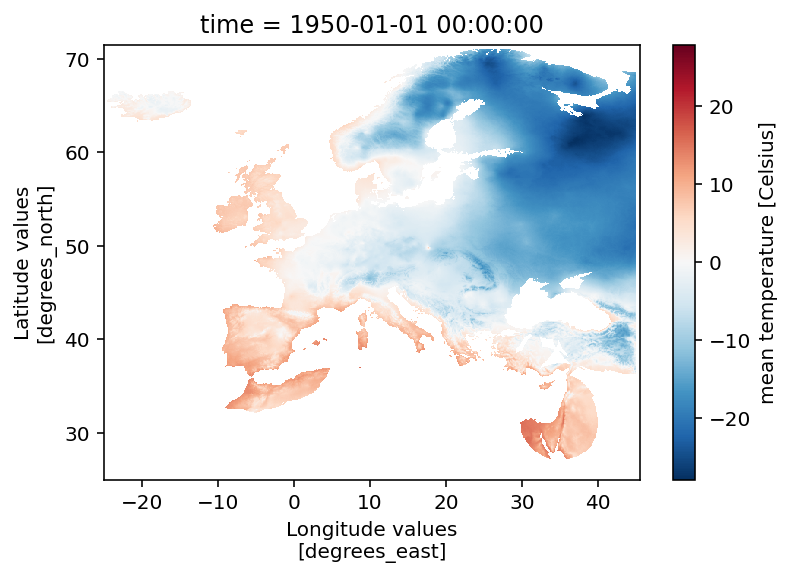

In [16]:
eobs_tg.tg.isel(time=0).plot()

In [11]:
%time regridder = xe.Regridder(eobs_tg, ds, "bilinear")
regridder

CPU times: user 8.28 s, sys: 530 ms, total: 8.81 s
Wall time: 10.3 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_465x705_433x433.nc 
Reuse pre-computed weights? False 
Input grid shape:           (465, 705) 
Output grid shape:          (433, 433) 
Periodic in longitude?      False

In [26]:
eobs_tg_mon = eobs_tg.resample(time="1M").mean()

In [27]:
eobs_tg_mon

<xarray.Dataset>
Dimensions:    (latitude: 465, longitude: 705, time: 846)
Coordinates:
  * time       (time) object 1950-01-31 00:00:00 ... 2020-06-30 00:00:00
  * longitude  (longitude) float64 -24.95 -24.85 -24.75 ... 45.25 45.35 45.45
  * latitude   (latitude) float64 25.05 25.15 25.25 25.35 ... 71.25 71.35 71.45
Data variables:
    tg         (time, latitude, longitude) float32 dask.array<chunksize=(1, 322, 235), meta=np.ndarray>

In [29]:
eobs_ymean = eobs_tg_mon.groupby("time.year").mean(dim=('time', 'longitude', 'latitude'))

In [ ]:
eobs_ymean_ = eobs_ymean.persist()
progress(eobs_ymean_)